In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
ticker_symbol = '^NSEI'

start_date = "2010-01-01"
end_date = "2023-01-01"

stock_data = yf.download(ticker_symbol, start = start_date, end = end_date)
df = pd.DataFrame(stock_data)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0


In [4]:
close = df['Adj Close']
close.head()

Date
2010-01-04    5232.200195
2010-01-05    5277.899902
2010-01-06    5281.799805
2010-01-07    5263.100098
2010-01-08    5244.750000
Name: Adj Close, dtype: float64

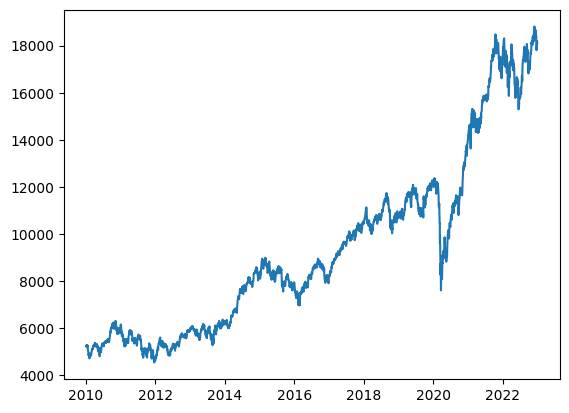

In [5]:
plt.plot(close)

###Stationarity of the Series
Applying Dickey - Fuller Test

In [6]:
result = adfuller(close)
print('The p value of the series is:', result[1])

The p value of the series is: 0.9789336244334811


Clearly the data is non stationary. We don't bother to remove the seasonality
for feeding into LSTM model as they are proficient enough to capture patterns.


###Plotting ACF and PACF

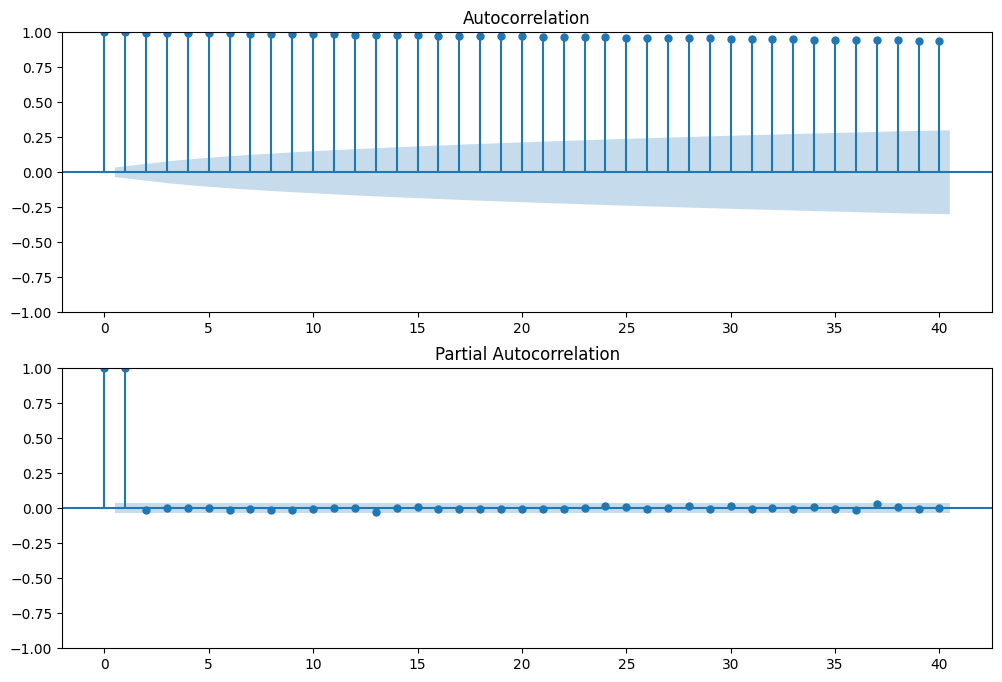

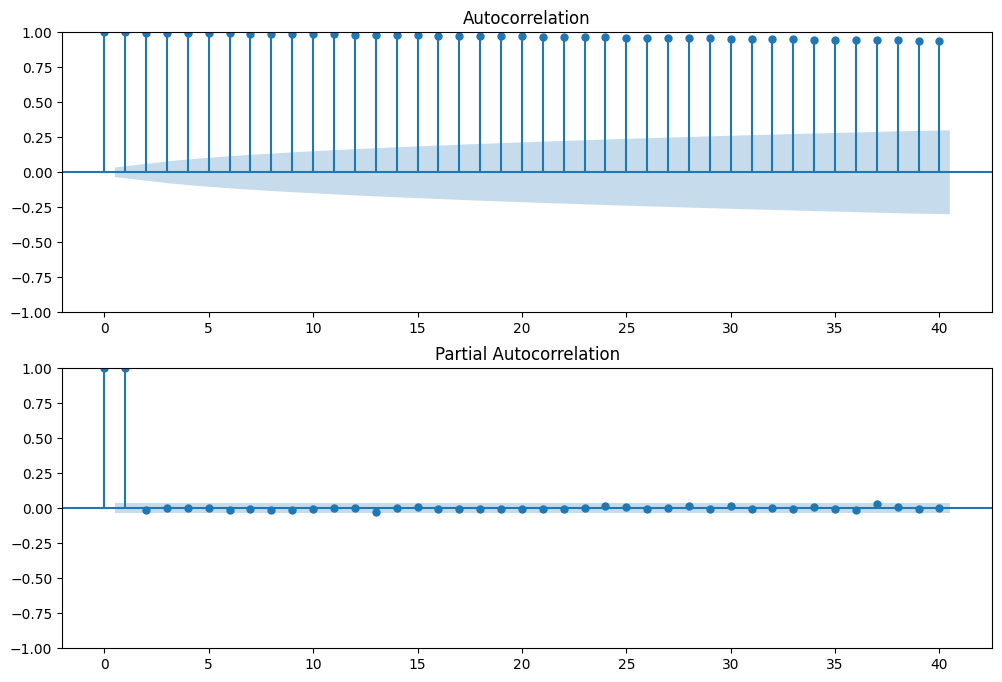

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF
plot_acf(close, lags=40, ax=ax1)

# Plot the PACF
plot_pacf(close, lags=40, ax=ax2)

The PACF plot suggests that the price is strongly correlated just to the previous lag values.

### Trend and Seasonality Decomposition

In [8]:
close = close.reset_index()

In [9]:
close.dtypes

Date         datetime64[ns]
Adj Close           float64
dtype: object

In [10]:
close.set_index('Date', inplace = True)

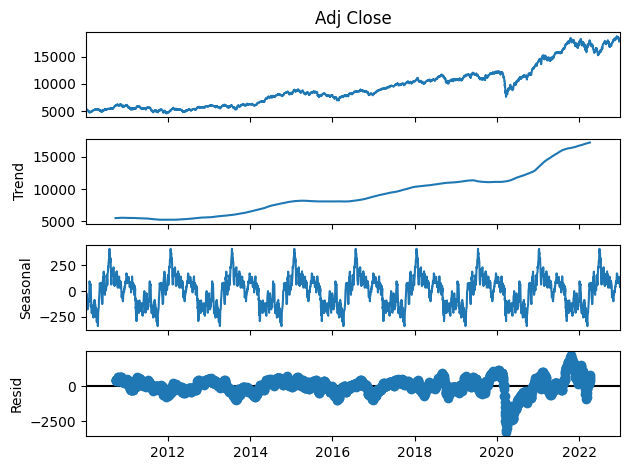

In [11]:
result = seasonal_decompose(df['Adj Close'], model='additive', period=365)
result.plot()
plt.show()

In [12]:
trend = pd.DataFrame(result.trend)

Day wise seasonal patterns is observed. This can be an important feature while training LSTM model.

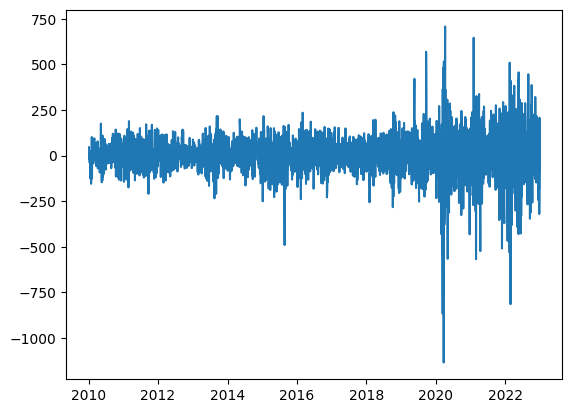

In [13]:
plt.plot(close.diff(1))

### Dividing the data into train, validation and test sets

In [14]:
print(f'The size of dataset is: {len(close)}')

The size of dataset is: 3189


In [15]:
# dividing the train, validation and test as: 60:20:20
train_dataset = close[:int(0.6*len(close))]
validation_dataset = close[int(0.6*len(close)): int(0.8*len(close))]
test_dataset = close[int(0.8*len(close)):]

In [16]:
len(train_dataset)+len(validation_dataset)+len(test_dataset)

3189

In [17]:
train_dataset

,Adj Close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000
...,...
2017-10-23,10184.849609
2017-10-24,10207.700195
2017-10-25,10295.349609


### Applying ARIMA model to the Time Series data

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [19]:
# since the significant lag is k=2
p = d = q = range(0, 2)                               # p -> lags, d -> differencing: stationary, q -> MA
pdq = list(itertools.product(p, d, q))

In [20]:
for params in pdq:
  model = ARIMA(train_dataset, order = params)
  result = model.fit()
  print('ARIMA{} AIC:{}'.format(params, result.aic))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) AIC:33499.557246804194


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) AIC:31330.710163926604
ARIMA(0, 1, 0) AIC:21441.377230666883
ARIMA(0, 1, 1) AIC:21430.712704720696


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0) AIC:21463.497909492078


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) AIC:21457.316908874855
ARIMA(1, 1, 0) AIC:21431.414552275382


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) AIC:21431.230179293285


In [21]:
arima_model = ARIMA(train_dataset, order = (1, 1, 1))
arima_fitted = arima_model.fit()
arima_fitted.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1913
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10712.615
Date:                Fri, 27 Oct 2023   AIC                          21431.230
Time:                        08:06:13   BIC                          21447.898
Sample:                             0   HQIC                         21437.364
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3743      0.210     -1.778      0.075      -0.787       0.038
ma.L1          0.4542      0.200      2.268      0.023       0.062       0.847
sigma2      4312.8792     97.341     44.307      0.000    4122.095    4503.663
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               422.06
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
len(validation_dataset)

638

In [23]:
forecast_steps = 10
forecast = arima_fitted.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
forecast

1913    10321.127692
1914    10321.847156
1915    10321.577854
1916    10321.678656
1917    10321.640925
1918    10321.655048
1919    10321.649762
1920    10321.651740
1921    10321.651000
1922    10321.651277
Name: predicted_mean, dtype: float64

In [25]:
train_dataset.iloc[1900]

Adj Close    10016.950195
Name: 2017-10-10 00:00:00, dtype: float64

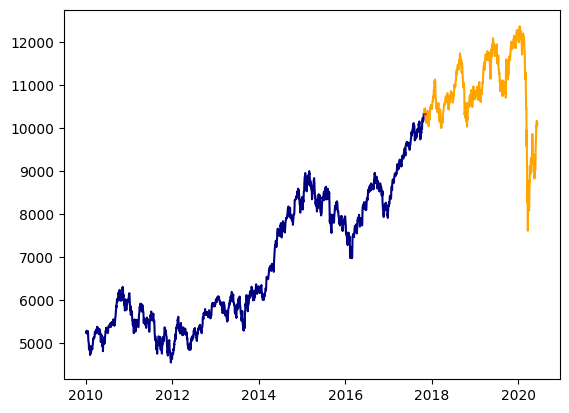

In [26]:
plt.plot(train_dataset, label="Training",color="navy")
plt.plot(validation_dataset, label="Actual",color="orange")
plt.plot(validation_dataset.index[:10],forecast, color = "red")

In [27]:
!pip install prophet

In [28]:
!pip install pystan
!pip install cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.4 MB/s eta 0:00:00


### Using LSTM for prediction

In [29]:
!pip install mplfinance
!pip install ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=9bb3c2b625caf667920fe83231fff965cae5d7c8c01edc29db113d67c2939de8
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [31]:
import mplfinance as mplf
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from ta.trend import ADXIndicator
import ta
from ta.volume import OnBalanceVolumeIndicator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam

In [32]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0


In [33]:
def add_technical_indicators(data):
  # technical indicators to be added are - RSI, Fast and Slow EMA, VWAP, ATR

  #RSI
  rsi_period = 14  # RSI period (usually 14)
  indicator = RSIIndicator(close=data['Adj Close'], window=rsi_period)
  data['RSI'] = indicator.rsi()

  #EMA
  fast_ema_period = 12
  slow_ema_period = 26

  data['fast_EMA'] = data['Adj Close'].ewm(span=fast_ema_period, adjust=False).mean()
  data['slow_EMA'] = data['Adj Close'].ewm(span=slow_ema_period, adjust=False).mean()

  #VWAP
  #data['VWAP'] = (data['Adj Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

  #ATR
  period = 14  # You can change this to your desired period
  # Calculate True Range (TR)
  data['High-Low'] = data['High'] - data['Low']
  data['High-PrevClose'] = abs(data['High'] - data['Adj Close'].shift(1))
  data['Low-PrevClose'] = abs(data['Low'] - data['Adj Close'].shift(1))

  data['TR'] = data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
  # Calculate ATR
  atr = data['TR'].rolling(window=period).mean()
  data['ATR'] = atr

  data.drop(columns = ['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TR'], inplace = True)

  return data

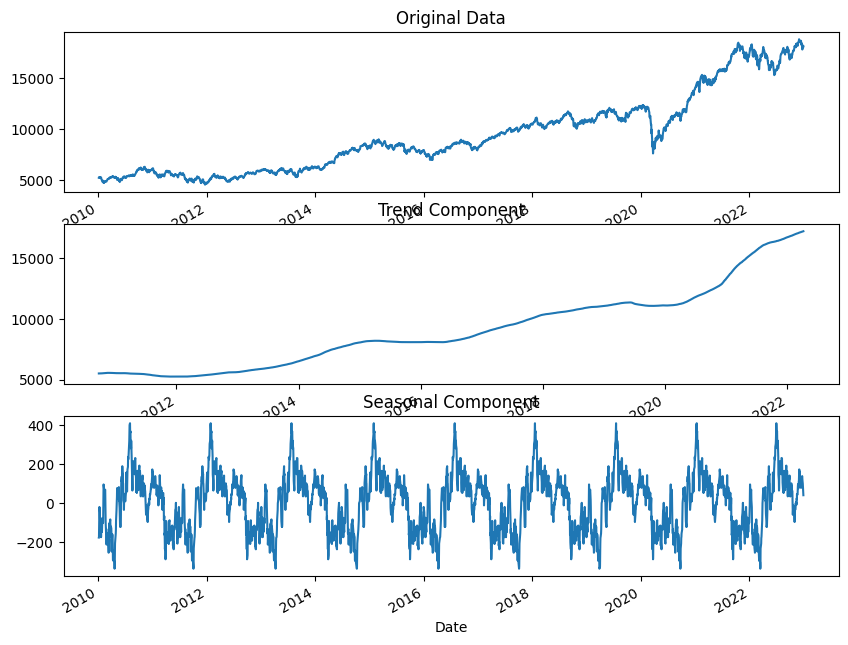

In [34]:
result = seasonal_decompose(df['Adj Close'], model='additive', period = 365)

# Access the seasonal and trend components
seasonal_component = result.seasonal
trend_component = result.trend

# Plot the decomposed components
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
df['Adj Close'].plot(ax=axes[0], title='Original Data')
trend_component.plot(ax=axes[1], title='Trend Component')
seasonal_component.plot(ax=axes[2], title='Seasonal Component')
plt.show()
seasonality = result.seasonal
trend = result.trend

# Create a new DataFrame to store trend and seasonality
decomposition_df = pd.DataFrame({'Date': df.index, 'Seasonality': seasonality, 'Trend': trend, 'Residual': result.resid})

In [35]:
df = add_technical_indicators(df)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,fast_EMA,slow_EMA,ATR
Date,,,,,,,,,,
2022-12-26,17830.400391,18084.099609,17774.250000,18014.599609,18014.599609,176700,40.672810,18254.384720,18311.225411,211.092913
2022-12-27,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300,44.800308,18235.602576,18297.971735,214.085798
2022-12-28,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900,44.522543,18218.202180,18284.973829,215.278599
2022-12-29,18045.699219,18229.699219,17992.800781,18191.000000,18191.000000,281100,46.996085,18214.017229,18278.012804,214.014230
2022-12-30,18259.099609,18265.250000,18080.300781,18105.300781,18105.300781,192000,44.332909,18197.291622,18265.219321,214.664062


In [36]:
df.isna().sum()/len(df)

Open         0.000000
High         0.000000
Low          0.000000
Close        0.000000
Adj Close    0.000000
Volume       0.000000
RSI          0.004077
fast_EMA     0.000000
slow_EMA     0.000000
ATR          0.004077
dtype: float64

In [37]:
df.dropna(inplace = True)

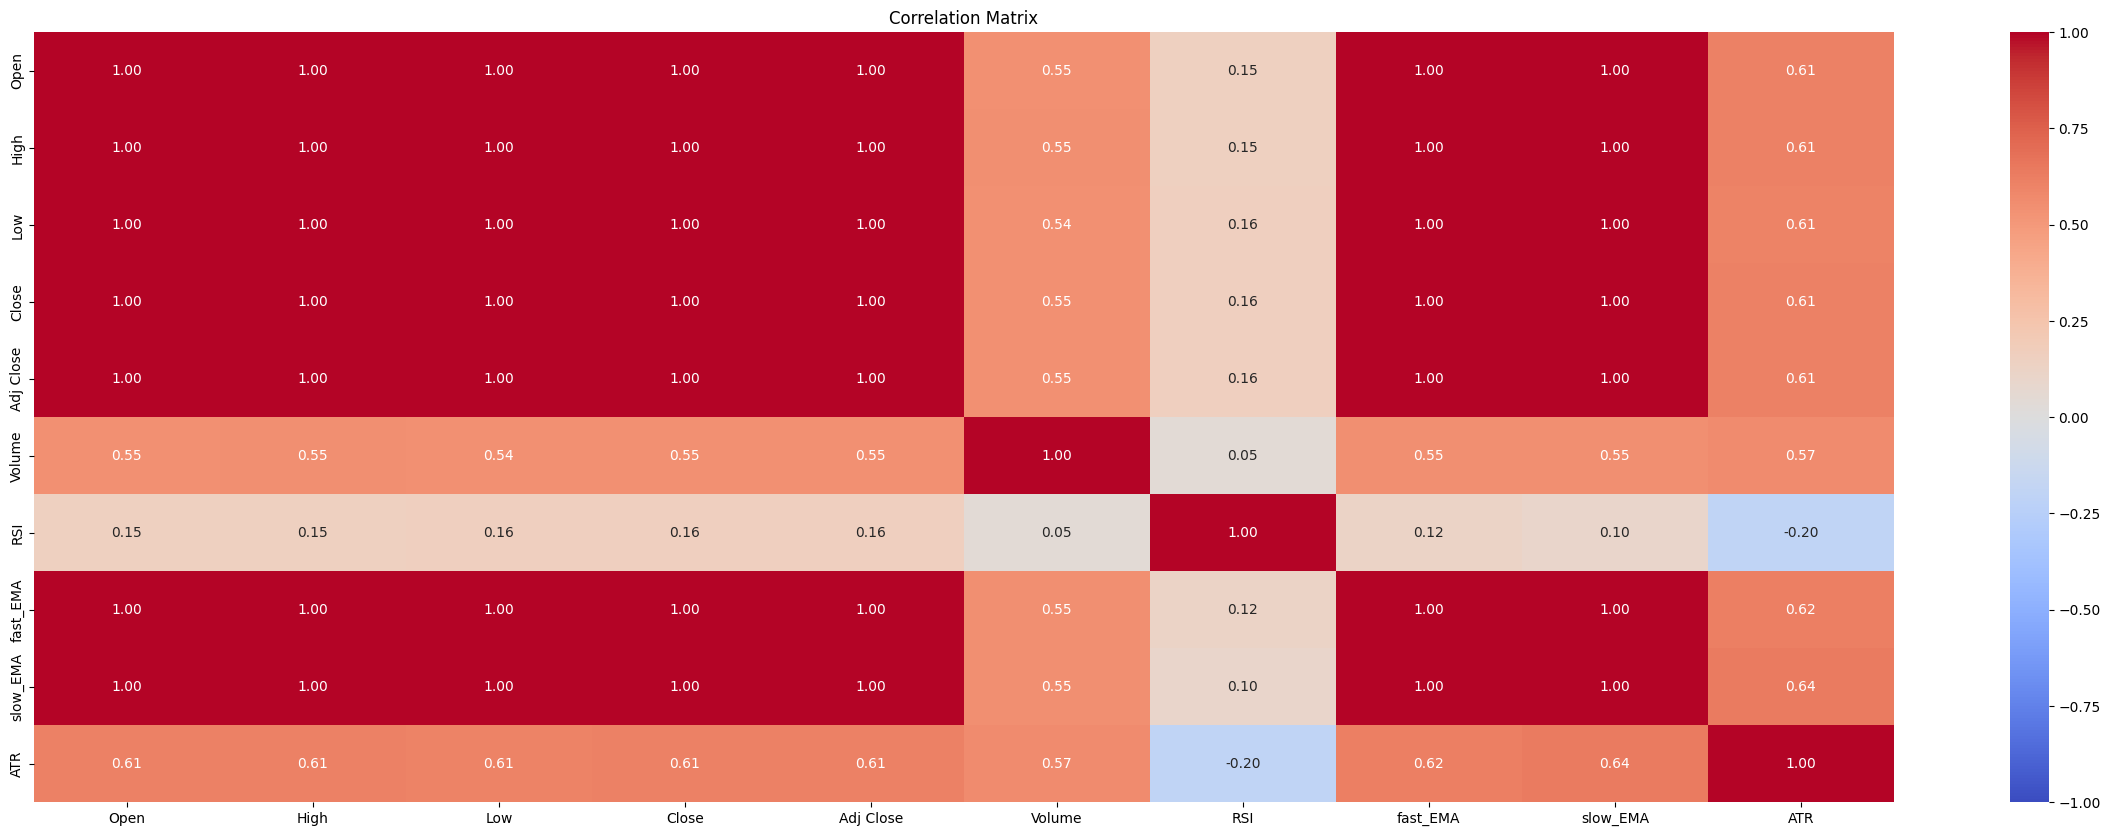

In [38]:
plt.figure(figsize=(30, 10))  # Adjust the figure size as needed
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [39]:
df.drop(columns = ['Open', 'High', 'Low', 'Close'], inplace = True)

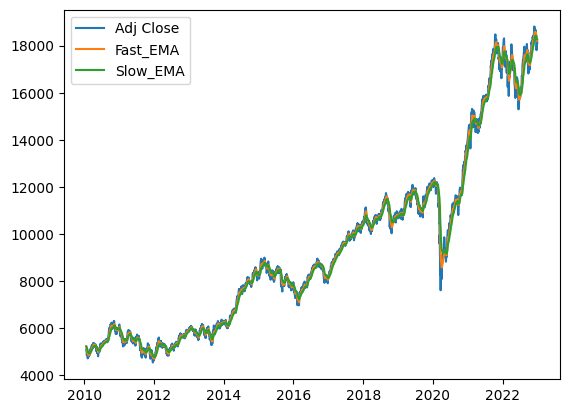

In [40]:
plt.plot(df['Adj Close'], label = 'Adj Close')
plt.plot(df['fast_EMA'], label = 'Fast_EMA')
plt.plot(df['slow_EMA'], label = 'Slow_EMA')
plt.legend()

####Normalising the values

(array([801., 289., 636., 273., 495., 164.,  49., 140., 159., 170.]),
 array([ 4544.20019531,  5971.03017578,  7397.86015625,  8824.69013672,
        10251.52011719, 11678.35009766, 13105.18007812, 14532.01005859,
        15958.84003906, 17385.67001953, 18812.5       ]),
 <BarContainer object of 10 artists>)

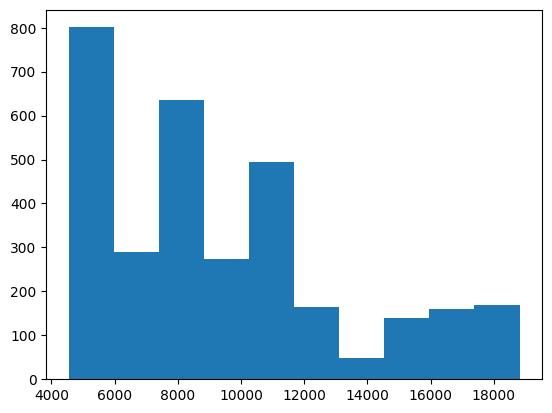

In [41]:
plt.hist(df['Adj Close'])

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns = df.columns)
df.head()

,Adj Close,Volume,RSI,fast_EMA,slow_EMA,ATR
Date,,,,,,
2010-01-21,0.038543,0.0,0.170585,0.037000,0.033316,0.026613
2010-01-22,0.034468,0.0,0.110184,0.034964,0.032263,0.033719
2010-01-25,0.032499,0.0,0.086419,0.032930,0.031136,0.033384
2010-01-27,0.021649,0.0,0.000000,0.029491,0.029252,0.046419
2010-01-28,0.022641,0.0,0.037817,0.026739,0.027584,0.051350


#### Dividing into test and train set

In [44]:
train_dataset = df[:int(0.6*len(df))]
validation_dataset = df[int(0.6*len(df)): int(0.8*len(df))]
test_dataset = df[int(0.8*len(df)):]

In [45]:
train_dataset.reset_index(inplace = True)
validation_dataset.reset_index(inplace = True)
test_dataset.reset_index(inplace = True)

train_dataset.drop(columns = ['Date'], inplace = True)
validation_dataset.drop(columns = ['Date'], inplace = True)
test_dataset.drop(columns = ['Date'], inplace = True)

<ipython-input-45-4cb0955387b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset.drop(columns = ['Date'], inplace = True)
<ipython-input-45-4cb0955387b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_dataset.drop(columns = ['Date'], inplace = True)
<ipython-input-45-4cb0955387b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset.drop(columns = ['Date'], inplace = True)


In [46]:
train_dataset

,Adj Close,Volume,RSI,fast_EMA,slow_EMA,ATR
0,0.038543,0.000000,0.170585,0.037000,0.033316,0.026613
1,0.034468,0.000000,0.110184,0.034964,0.032263,0.033719
2,0.032499,0.000000,0.086419,0.032930,0.031136,0.033384
3,0.021649,0.000000,0.000000,0.029491,0.029252,0.046419
4,0.022641,0.000000,0.037817,0.026739,0.027584,0.051350
...,...,...,...,...,...,...
1900,0.407859,0.130812,0.780775,0.398108,0.392175,0.049912
1901,0.405872,0.128437,0.738321,0.399300,0.393293,0.049755
1902,0.413245,0.143733,0.807586,0.401476,0.394899,0.050268
1903,0.412074,0.111264,0.782902,0.403132,0.396295,0.041180


#### Preparing the input

In [47]:
def create_input_target(data, look_back):
  X, y = [], []
  for i in range(len(data) - look_back):
    X.append(data.iloc[i:(i + look_back)])
    y.append(data.iloc[i + look_back]['Adj Close'])

  return np.array(X), np.array(y)


In [48]:
X_train, y_train = create_input_target(train_dataset, 2)
X_val, y_val = create_input_target(validation_dataset, 2)
X_test, y_test = create_input_target(test_dataset, 2)

In [49]:
# model

model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape=(2, 6)))
model_lstm.add(Dense(1))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

In [50]:
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=8, validation_data= (X_val, y_val))

Epoch 1/100
238/238 [==============================] - 4s 7ms/step - loss: 0.0092 - val_loss: 9.5995e-04
Epoch 2/100
238/238 [==============================] - 2s 9ms/step - loss: 3.3352e-04 - val_loss: 0.0010
Epoch 3/100
238/238 [==============================] - 3s 13ms/step - loss: 9.8184e-05 - val_loss: 7.4557e-04
Epoch 4/100
238/238 [==============================] - 2s 8ms/step - loss: 6.7377e-05 - val_loss: 7.7081e-04
Epoch 5/100
238/238 [==============================] - 2s 8ms/step - loss: 5.9235e-05 - val_loss: 7.5528e-04
Epoch 6/100
238/238 [==============================] - 2s 10ms/step - loss: 5.5845e-05 - val_loss: 5.7694e-04
Epoch 7/100
238/238 [==============================] - 2s 10ms/step - loss: 5.1102e-05 - val_loss: 4.3129e-04
Epoch 8/100
238/238 [==============================] - 2s 10ms/step - loss: 4.9518e-05 - val_loss: 6.5889e-04
Epoch 9/100
238/238 [==============================] - 3s 12ms/step - loss: 4.5832e-05 - val_loss: 3.7261e-04
Epoch 10/100
238/238 [

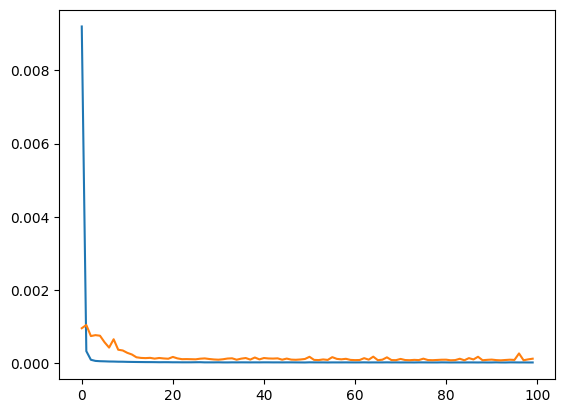

In [73]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.label()

In [52]:
predictions = model_lstm.predict(X_test)

20/20 [==============================] - 1s 3ms/step


In [53]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)

In [54]:
print(np.sqrt(mse))

0.06436583374686212


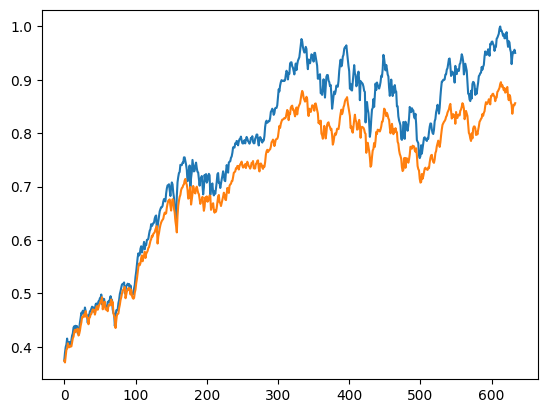

In [55]:
plt.plot(y_test)
plt.plot(predictions)

In [56]:
predict_validation = model_lstm.predict(X_val)
mse_validation = mean_squared_error(y_val, predict_validation)
print(f'The RMSE on validation set is: {np.sqrt(mse_validation)}')

20/20 [==============================] - 0s 3ms/step
The RMSE on validation set is: 0.011308747835416614


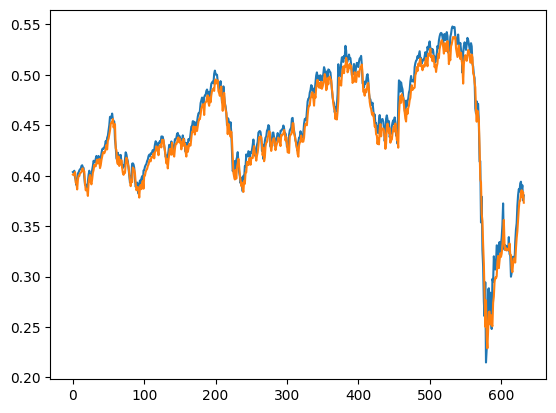

In [57]:
plt.plot(y_val)
plt.plot(predict_validation)

In [58]:
ticker_symbol = "^NSEI"

start_date_c = "2023-01-01"
end_date_c = "2023-10-23"

stock_data_c = yf.download(ticker_symbol, start = start_date_c, end = end_date_c)
df_c = pd.DataFrame(stock_data_c)

[*********************100%%**********************]  1 of 1 completed


In [59]:
df_c.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,18131.699219,18215.150391,18086.500000,18197.449219,18197.449219,256100
2023-01-03,18163.199219,18251.949219,18149.800781,18232.550781,18232.550781,208700
2023-01-04,18230.650391,18243.000000,18020.599609,18042.949219,18042.949219,235200
2023-01-05,18101.949219,18120.300781,17892.599609,17992.150391,17992.150391,269900
2023-01-06,18008.050781,18047.400391,17795.550781,17859.449219,17859.449219,238200


In [60]:
df_c = add_technical_indicators(df_c)
#df_c = add_macroeconomic_data(df_c)
#df_c = add_timeseries_data(df_c)
df_c.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,fast_EMA,slow_EMA,ATR
Date,,,,,,,,,,
2023-10-16,19737.250000,19781.300781,19691.849609,19731.750000,19731.750000,181000,52.335213,19697.277641,19680.893237,157.035854
2023-10-17,19843.199219,19849.750000,19775.650391,19811.500000,19811.500000,185800,55.468921,19714.850311,19690.567812,161.042969
2023-10-18,19820.449219,19840.949219,19659.949219,19671.099609,19671.099609,198900,49.321167,19708.119434,19689.125723,161.350167
2023-10-19,19545.199219,19681.800781,19512.349609,19624.699219,19624.699219,230300,47.449467,19695.285555,19684.353389,153.843052
2023-10-20,19542.150391,19593.800781,19518.699219,19542.650391,19542.650391,198300,44.251553,19671.803222,19673.856871,146.935965


In [61]:
len(df_c)

199

In [62]:
df_c.isna().sum()/len(df_c)

Open         0.000000
High         0.000000
Low          0.000000
Close        0.000000
Adj Close    0.000000
Volume       0.000000
RSI          0.065327
fast_EMA     0.000000
slow_EMA     0.000000
ATR          0.065327
dtype: float64

In [63]:
df_c.dropna(inplace = True)

In [64]:
df_c = pd.DataFrame(scaler.fit_transform(df_c), index = df_c.index, columns = df_c.columns)
df_c.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,fast_EMA,slow_EMA,ATR
Date,,,,,,,,,,
2023-01-19,0.359373,0.345952,0.374211,0.358082,0.358082,0.341421,0.433943,0.337104,0.329114,0.614102
2023-01-20,0.358051,0.342867,0.359807,0.333385,0.333385,0.340560,0.344870,0.336496,0.327601,0.614447
2023-01-23,0.358948,0.348293,0.374120,0.361377,0.361377,0.290739,0.445385,0.340970,0.328941,0.633361
2023-01-24,0.379551,0.360521,0.378724,0.361300,0.361300,0.311414,0.445091,0.344742,0.330174,0.575814
2023-01-25,0.351053,0.328677,0.308298,0.291596,0.291596,0.369275,0.221278,0.335509,0.324493,0.601444


In [65]:
df_c.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,fast_EMA,slow_EMA,ATR
Date,,,,,,,,,,
2023-10-16,0.868141,0.860427,0.867373,0.858159,0.858159,0.259871,0.447201,0.928828,0.981458,0.335566
2023-10-17,0.901467,0.882083,0.892756,0.882718,0.882718,0.266762,0.508542,0.935097,0.985394,0.367914
2023-10-18,0.894311,0.879299,0.857710,0.839482,0.839482,0.285571,0.388203,0.932696,0.984808,0.370394
2023-10-19,0.807732,0.828947,0.813001,0.825193,0.825193,0.330653,0.351566,0.928117,0.982866,0.309791
2023-10-20,0.806773,0.801105,0.814924,0.799926,0.799926,0.284709,0.288969,0.919739,0.978594,0.254033


In [66]:
df_c.drop(columns = ['Open', 'High', 'Low', 'Close'], inplace = True)

In [67]:
X, y = create_input_target(df_c, 2)

In [68]:
X

array([[[0.35808187, 0.34142139, 0.4339428 , 0.33710445, 0.32911352,
         0.61410169],
        [0.33338466, 0.34055994, 0.34487047, 0.33649551, 0.32760125,
         0.61444744]],

       [[0.33338466, 0.34055994, 0.34487047, 0.33649551, 0.32760125,
         0.61444744],
        [0.36137727, 0.29073941, 0.445385  , 0.34096964, 0.32894102,
         0.63336096]],

       [[0.36137727, 0.29073941, 0.445385  , 0.34096964, 0.32894102,
         0.63336096],
        [0.36130029, 0.31141421, 0.44509104, 0.34474171, 0.33017402,
         0.57581402]],

       ...,

       [[0.85815916, 0.25987078, 0.4472013 , 0.9288279 , 0.98145751,
         0.33556585],
        [0.88271803, 0.26676238, 0.5085417 , 0.93509739, 0.98539442,
         0.3679139 ]],

       [[0.88271803, 0.26676238, 0.5085417 , 0.93509739, 0.98539442,
         0.3679139 ],
        [0.83948197, 0.28557071, 0.38820319, 0.93269599, 0.98480758,
         0.37039381]],

       [[0.83948197, 0.28557071, 0.38820319, 0.93269599, 0.98480758

In [69]:
predict_new = model_lstm.predict(X)

6/6 [==============================] - 0s 3ms/step


In [70]:
y

array([0.36137727, 0.36130029, 0.29159572, 0.20302992, 0.21676429,
       0.22082957, 0.20671026, 0.20489325, 0.27992496, 0.25237863,
       0.23910618, 0.28535977, 0.29205764, 0.28067919, 0.25431894,
       0.30326708, 0.32975063, 0.33590959, 0.30768602, 0.27701449,
       0.2715021 , 0.18761747, 0.17436006, 0.16036405, 0.13785255,
       0.11052215, 0.1557755 , 0.11605018, 0.19995044, 0.23601106,
       0.2492378 , 0.19848769, 0.14407347, 0.06443817, 0.03025592,
       0.00834528, 0.01248694, 0.04773198, 0.01334944, 0.05002595,
       0.06369898, 0.04060286, 0.        , 0.01251762, 0.00204737,
       0.0417727 , 0.1277059 , 0.13950056, 0.18846433, 0.20142883,
       0.20909686, 0.23935278, 0.2670988 , 0.27190267, 0.23459462,
       0.22021368, 0.2074645 , 0.20921956, 0.20909686, 0.24585037,
       0.25381071, 0.26746809, 0.29870981, 0.3448864 , 0.37033845,
       0.3525388 , 0.40364317, 0.3461182 , 0.40629141, 0.40676837,
       0.42190414, 0.4163304 , 0.42181212, 0.44769481, 0.41309

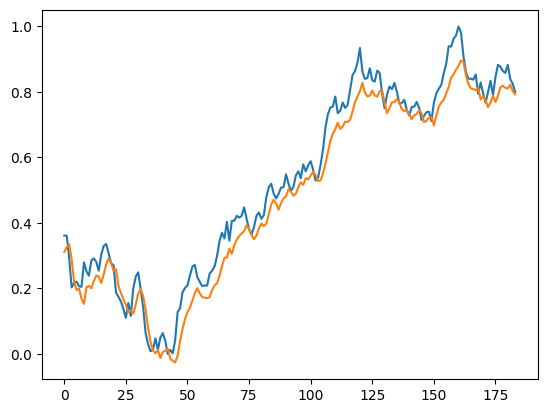

In [71]:
plt.plot(y)
plt.plot(predict_new)